# Week 12 - Generative models  

## Part 2: Variational Autoencoders (VAEs)



This part we move towards a non-linear mapping between the latent space z and the observation/input space x. Concretely, we will implement a VAE in Pyro.

Import required libraries:

In [1]:
# Install Pyro, if necessary
!pip install pyro-ppl

In [11]:
import numpy as np
import torch
import torch.nn as nn
from mnist_cached import MNISTCached as MNIST
from mnist_cached import setup_data_loaders
from vae_plots import mnist_test_tsne, plot_llk, plot_vae_samples

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

We will first use the same Iris data that we used for PPCA.

Load data:

In [12]:
# load csv
from sklearn import datasets
iris = datasets.load_iris()
X = torch.tensor(iris.data, dtype=torch.float32)
y = iris.target

# standardize data
X = (X-X.mean(dim=0)) / X.std(dim=0)

## Variational Autoencoders in Pyro

We will now implement a VAE in Pyro. Let us begin by recapping the model introduced in the class. The generative process can be summarize as follows:

1. For each observation $n \in \{1,\dots,N\}$
    1. Sample latent projection $\textbf{z}_n \sim \mathcal{N}(\textbf{z}_n|\textbf{0}, \textbf{I})$
    2. Sample observation $\textbf{x}_n \sim \mathcal{N}(\textbf{x}_n|f_{\boldsymbol\theta}(\textbf{z}_n))$

Note that the neural network $f$ is outputting both the mean and variance of the Gaussian. 

Our goal is to compute the posterior distribution over the latent variables $\textbf{z}_n$, while jointly finding point estimates for the parameters of that neural network $\boldsymbol\theta$. Note that you could also treat $\boldsymbol\theta$ as latent variables and perform inference on them as well (i.e. a Bayesian neural network), but, for this particular model, point estimates are usually sufficient. 

We will also need an approximate distribution $q(\textbf{z})$ for VI. As we saw in the slides, we will use a second neural network $g$ to parameterize this variational distribution $q$. Therefore, we can represent the entire process of the training a VAE as follows:

<img style="width:50%" src="http://mlsm.man.dtu.dk/vae.png">

In the diagram, $g$ is the encoder network and $f$ is the decoder network. Lets begin by implementing those two neural networks in Torch:

In [13]:
# define the PyTorch module that parameterizes the
# diagonal gaussian distribution q(z|x)
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, input_dim):
        self.input_dim = input_dim
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, self.input_dim)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale


# define the PyTorch module that parameterizes the
# observation likelihood p(x|z)
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, output_dim, binary=False):
        self.binary = binary
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, output_dim)
        if not self.binary:
            self.fc22 = nn.Linear(hidden_dim, output_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x input_dim
        if self.binary:
            out = torch.sigmoid(self.fc21(hidden))
        else:
            out = (self.fc21(hidden), self.softplus(self.fc22(hidden)))
        return out

Now that we have defined $f$ and $g$, we can use them to implement the model() and guide() in Pyro:

- The guide() will take the observations $\textbf{x}$ as input, pass them through the encoder network $g$, and use the output of the encoder to parameterize the variational approximation $q(\textbf{z})$. You can do a forward pass through the encoder using: ``self.encoder.forward(x)``. 

- The model() just follows the generative process of the VAE described above. For each observation $n$, it samples $\textbf{z}_n \sim \mathcal{N}(\textbf{z}_n|\textbf{0}, \textbf{I})$ and passes the samples through the decoder network $f$, in order to produce the parameters of the observation distributon $\mathcal{N}(\textbf{x}_n|f_{\boldsymbol\theta}(\textbf{z}_n))$. You can do a forward pass through the decoder using: ``self.decoder.forward(z)``. 

Can try to you implement the guide() and model() for the Pyro model below? 

In [39]:

# define a PyTorch module for the VAE
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, input_dim=784, binary=False, use_cuda=False):
        self.input_dim = input_dim
        self.binary = binary
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim, input_dim)
        self.decoder = Decoder(z_dim, hidden_dim, input_dim, binary=binary)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)

        with pyro.plate("data", x.shape[0]):
            z_loc = torch.zeros(x.shape[0], self.z_dim)
            z_scale = torch.ones(x.shape[0], self.z_dim)
            z = pyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))
            img = self.decoder.forward(z)
            if self.binary:
                # sample from the Bernoulli distribution
                pyro.sample("obs", dist.Bernoulli(img, validate_args=False).to_event(1), obs=x.reshape(-1, self.input_dim))
            else:
                # sample from the Gaussian distribution
                loc, scale = img
                pyro.sample("obs", dist.Normal(loc, scale, validate_args=False).to_event(1), obs=x.reshape(-1, self.input_dim))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder.forward(x)
            z = pyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))


    # define a helper function for reconstructing images (this will useful later - ignore for now)
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

Now that the Pyro model is defined, lets run Bayesian inference on it. Note that the encoder and decoder networks will be trained jointly as part of the VI process.

In [16]:
# clear param store
pyro.clear_param_store()

# setup the VAE
vae = VAE(z_dim=2, hidden_dim=20, input_dim=4, use_cuda=False)

# setup the optimizer
adam_args = {"lr": 1.0e-3}
optimizer = Adam(adam_args)

# setup the inference algorithm
#elbo = Trace_ELBO()
elbo = Trace_ELBO(num_particles=3)
svi = SVI(vae.model, vae.guide, optimizer, loss=elbo)

train_elbo = {}
test_elbo = {}
# training loop
num_epochs = 5000
for epoch in range(num_epochs):
    # do ELBO gradient and accumulate loss
    epoch_loss = svi.step(X)

    if epoch % 100 == 0:
        # report training diagnostics
        total_epoch_loss_train = epoch_loss / len(X)
        train_elbo[epoch] = total_epoch_loss_train
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

[epoch 000]  average training loss: 21.2884
[epoch 100]  average training loss: 5.9377
[epoch 200]  average training loss: 5.6529
[epoch 300]  average training loss: 5.5891
[epoch 400]  average training loss: 5.3706
[epoch 500]  average training loss: 4.9130
[epoch 600]  average training loss: 4.1842
[epoch 700]  average training loss: 3.8169
[epoch 800]  average training loss: 3.5806
[epoch 900]  average training loss: 3.4729
[epoch 1000]  average training loss: 3.4277
[epoch 1100]  average training loss: 3.4059
[epoch 1200]  average training loss: 3.3760
[epoch 1300]  average training loss: 3.3769
[epoch 1400]  average training loss: 3.3563
[epoch 1500]  average training loss: 3.3295
[epoch 1600]  average training loss: 3.2887
[epoch 1700]  average training loss: 3.2662
[epoch 1800]  average training loss: 3.2765
[epoch 1900]  average training loss: 3.2559
[epoch 2000]  average training loss: 3.2360
[epoch 2100]  average training loss: 3.2231
[epoch 2200]  average training loss: 3.18

As we did for PPCA, we can look at the reconstructions of the inputs $\textbf{x}$ and see how good they are.

In [17]:
out = vae.reconstruct_img(X)
reconstruction_mean, reconstruction_var = out
reconstruction_mean = reconstruction_mean.cpu().detach().numpy()
mae = torch.mean(torch.abs(X-reconstruction_mean))
rmse = torch.sqrt(torch.mean((X-reconstruction_mean)**2))
mae, rmse

/var/folders/j2/78rqs17d54vbj7hx80n7ztwr0000gp/T/ipykernel_13838/782574030.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mae = torch.mean(torch.abs(X-reconstruction_mean))
/var/folders/j2/78rqs17d54vbj7hx80n7ztwr0000gp/T/ipykernel_13838/782574030.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rmse = torch.sqrt(torch.mean((X-reconstruction_mean)**2))


(tensor(0.3001), tensor(0.4643))

And as we did for the PPCA model, we can also look at the projections of the data in the latent space:

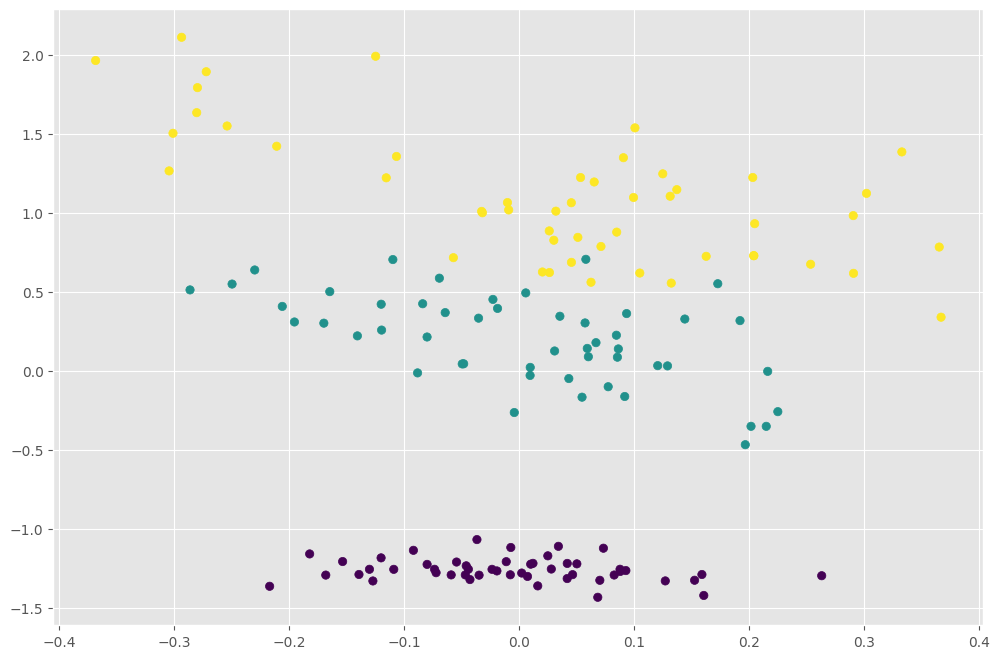

In [18]:
z_loc, z_scale = vae.encoder(X)
z_loc = z_loc.cpu().detach().numpy()
plt.scatter(z_loc[:,0], z_loc[:,1], c=y);

## VAE application in computer vision

The Iris data is relatively simple. Lets now look at a more complex application in computer vision, where the VAE can really start to shine. Concretely, we will try to model images of digits using a VAE - the MNIST dataset. In the code below, we will load the datasets and train the VAE model on it. We will use a larger dimensionality (``z_dim=50``) of the latent space $\textbf{z}$.

Note: training the VAE on this dataset will take a few minutes (about 5-10 minutes, depending on your computer).

In [41]:
use_cuda = False

# clear param store
pyro.clear_param_store()

# setup MNIST data loaders
# train_loader, test_loader
train_loader, test_loader = setup_data_loaders(MNIST, use_cuda=use_cuda, batch_size=256)

# setup the VAE
vae = VAE(use_cuda=use_cuda, z_dim=50, hidden_dim=400, input_dim=784, binary=True)

# setup the optimizer
adam_args = {"lr": 1.0e-3}
optimizer = Adam(adam_args)

# setup the inference algorithm
elbo = Trace_ELBO()
svi = SVI(vae.model, vae.guide, optimizer, loss=elbo)

train_elbo = {}
test_elbo = {}
# training loop
num_epochs = 100
for epoch in range(num_epochs):
    # initialize loss accumulator
    epoch_loss = 0.0
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    if epoch % 5 == 0:
        # report training diagnostics
        normalizer_train = len(train_loader.dataset)
        total_epoch_loss_train = epoch_loss / normalizer_train
        train_elbo[epoch] = total_epoch_loss_train
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))
        
        # initialize loss accumulator
        test_loss = 0.0
        # compute the loss over the entire test set
        for i, (x, _) in enumerate(test_loader):
            # if on GPU put mini-batch into CUDA memory
            if use_cuda:
                x = x.cuda()
            # compute ELBO estimate and accumulate loss
            test_loss += svi.evaluate_loss(x)

        # report test diagnostics
        normalizer_test = len(test_loader.dataset)
    
        total_epoch_loss_test = test_loss / normalizer_test
        test_elbo[epoch] = total_epoch_loss_test
        print("[epoch %03d]  average test loss: %.4f" % (epoch, total_epoch_loss_test))
        plot_llk(train_elbo, test_elbo)

[epoch 000]  average training loss: 192.6287
[epoch 000]  average test loss: 158.1709
[epoch 005]  average training loss: 115.9430
[epoch 005]  average test loss: 113.7605
[epoch 010]  average training loss: 109.0597
[epoch 010]  average test loss: 108.1313
[epoch 015]  average training loss: 106.6710
[epoch 015]  average test loss: 106.0197
[epoch 020]  average training loss: 105.4098
[epoch 020]  average test loss: 104.9172
[epoch 025]  average training loss: 104.6510
[epoch 025]  average test loss: 104.4724
[epoch 030]  average training loss: 104.0653
[epoch 030]  average test loss: 103.9114
[epoch 035]  average training loss: 103.6304
[epoch 035]  average test loss: 103.4632
[epoch 040]  average training loss: 103.2881
[epoch 040]  average test loss: 103.6057
[epoch 045]  average training loss: 103.0818
[epoch 045]  average test loss: 103.3287
[epoch 050]  average training loss: 102.7621
[epoch 050]  average test loss: 103.0519
[epoch 055]  average training loss: 102.5422
[epoch 05

We can now look at the reconstructions produced by the VAE model for a subset of the digits in the dataset:

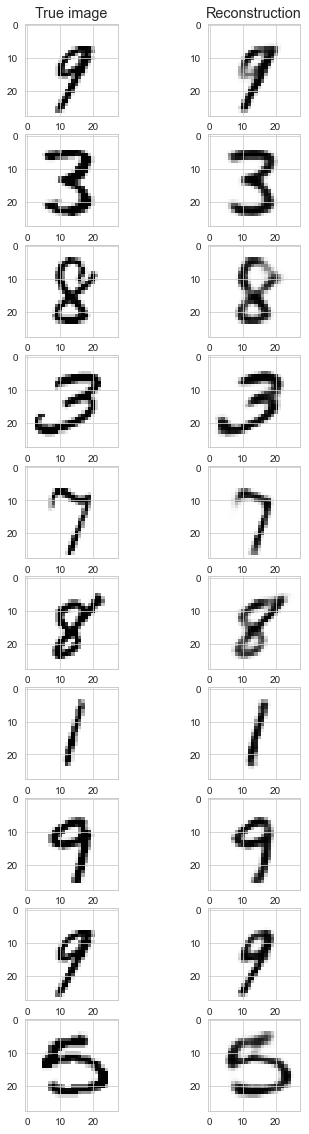

In [ ]:
# pick 10 random test images from the first mini-batch and visualize how well we're reconstructing them
fig, axs = plt.subplots(10,2, figsize=(6,20))
x = next(iter(test_loader))[0]
# if on GPU put mini-batch into CUDA memory
if use_cuda:
    x = x.cuda()
#plot_vae_samples(vae, vis)
reco_indices = np.random.randint(0, x.shape[0], 10)
for i in range(len(reco_indices)):
    index = reco_indices[i]
    test_img = x[index, :]
    reco_img = vae.reconstruct_img(test_img)
    #vis.image(
    #    test_img.reshape(28, 28).detach().cpu().numpy(),
    #    opts={"caption": "test image"},
    #)
    #vis.image(
    #    reco_img.reshape(28, 28).detach().cpu().numpy(),
    #    opts={"caption": "reconstructed image"},
    #)
    axs[i,0].imshow(test_img.reshape(28, 28).detach().cpu().numpy(), cmap="Greys")
    axs[i,1].imshow(reco_img.reshape(28, 28).detach().cpu().numpy(), cmap="Greys")
    
axs[0,0].set_title("True image")
axs[0,1].set_title("Reconstruction");

We can also try to visualize the projections of the digits in the latent space. However, in this case, the latent projections are still 50-dimensional!! We will need to project them down even further if we want to visualize them on a 2-D plot. For this, we will use a dimensionality reduction called t-SNE. t-SNE tries to project down the data while attempting to perserve the (Euclidean) distances between all pairs of data points (observations) in the dataset. Lets do that and see how it looks:

/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


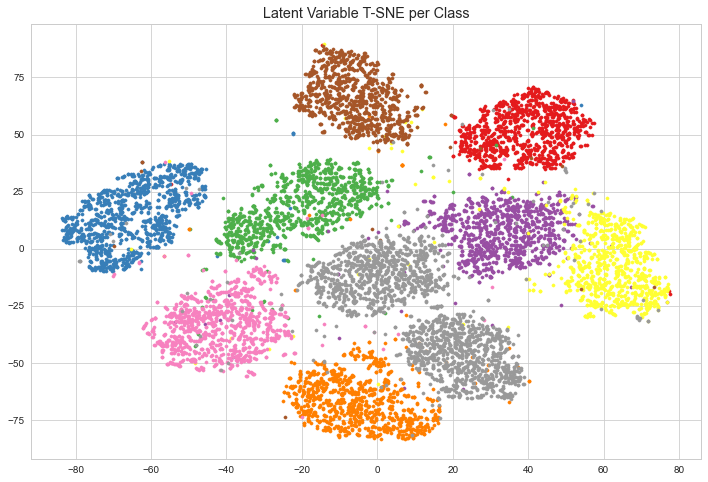

In [ ]:
mnist_test_tsne(vae=vae, test_loader=test_loader)

As we can see, the observations of the different digits are nicely separated (clustered) in the latent space $\textbf{z}$. I.e., all observations of the digit 5 are clustered together in the latent space, and similarly for other digits.

Lastly, since the VAE is a generative model, we can use it to sample new observations ("fake data"). We can do this by sampling $z$ from a standard Gaussian distribution and passing those samples through the decoder network. 

Lets do this to generate 10 new samples of digit images:

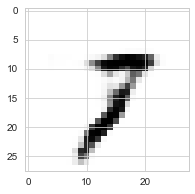

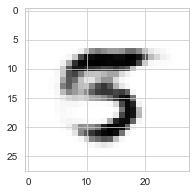

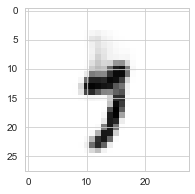

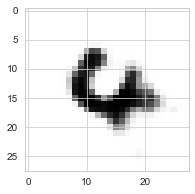

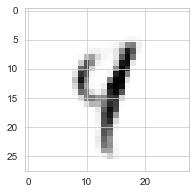

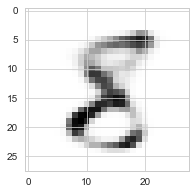

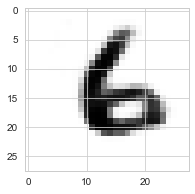

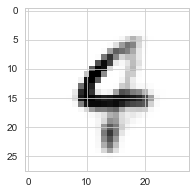

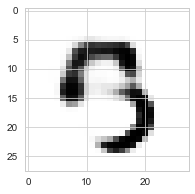

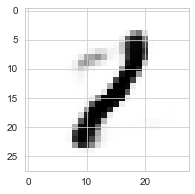

In [ ]:
for i in range(10):
    z_loc = torch.zeros(vae.z_dim, dtype=x.dtype, device=x.device)
    z_scale = torch.ones(vae.z_dim, dtype=x.dtype, device=x.device)
    z = dist.Normal(z_loc, z_scale).rsample()
    out = vae.decoder.forward(z)
    plt.figure(figsize=(3,3))
    plt.imshow(out.reshape(28, 28).detach().cpu().numpy(), cmap="Greys")

As you can see, some samples are somewhat realistic images of digits, while others are clearly not. You can probably obtain better samples (i.e., more realistic) if you train the VAE for longer.